In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Solving with decreasing learning rate for increasing causality paramater

###Constants

$C_0 = 0.05$</br>
$m_l = -81.1$</br>
$m_s = -478$</br>
$c_p = 820$</br>
$ρ = 7000$</br>
$L_f = 276000$</br>
$T_f = 1538$</br>
$T_∞ = 1540$</br>
$T_0 = 1510$</br>
$k_0 = 0.9$</br>
$Le = 300$</br>

$Ste = c_p(T_∞-T_0)/L_f$</br>
$θ_f = (T_f-T_0)/(T_∞-T_0)$</br>

Transcendental Equation to determine $\phi$ from constants</br>
5 Equations for analytical solutions parameterised in $\phi$

###Conditions

Domain $\epsilon \in [0,ϵ^*]$</br>
$C_s = k_0C_l^*$</br>
PDE1: $\frac{∂\theta_s}{∂\tau} = \frac{∂^2\theta_s}{∂\epsilon^2}$</br>
Domain $\epsilon \in [ϵ^*,1]$</br>
PDE2: $\frac{∂\theta_l}{∂\tau} = \frac{∂^2\theta_l}{∂\epsilon^2}$</br>
PDE3: $\frac{∂C_l}{∂\tau} = \frac{1}{Le}\frac{∂^2C_l}{∂\epsilon^2}$</br>
Interface ($ϵ=ϵ^*$)</br>
PDE4: $\frac{1}{Ste}\frac{∂\epsilon^*}{∂\tau} = \frac{∂\theta_s}{∂\epsilon}-\frac{∂\theta_l}{∂\epsilon}$</br>
PDE5: $\frac{-1}{Le}\frac{∂C_l}{∂ϵ}=C_l^*(1-k_0)\frac{dϵ^*}{dτ}$</br>

5 PDEs with 5 Variables [$θ_s(x,t)$, $θ_l(x,t)$, $C_s(x,t)$, $C_l(x,t)$, $ϵ^*(t)$]</br>
Model the 5 variables using 3 neural networks and optimise the NN parameters</br>

Initial ($\tau = 0$)</br>
$θ_l=1$ ; $C_l=C_0$ ; $ϵ^*=0$</br>
Interface ($ϵ=ϵ^*$)</br>
$θ_s=θ_l=θ^*$</br>
$C_l^* = (T_0-T_∞)(θ_f-θ^*)/m_l$</br>
Left BC ($ϵ=0$)</br>
$θ_s=0$

##Code

In [ ]:
import tensorflow as tf
import math as m

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float

a = tf.constant(1., dtype=DTYPE)
C0, Le, cp, Ti, T0, Tf, Lf, ml, k0 = 0.05*a, 300*a, 820*a, 1540*a, 1510*a, 1538*a, 276000*a, -81.1*a, 0.9*a
Ste = cp*(Ti-T0)/Lf
uf = (Tf-T0)/(Ti-T0)
pie = tf.constant(m.pi, dtype=DTYPE)

In [ ]:
from scipy.optimize import fsolve
import numpy as np
def func(x):
    return (uf - m.erf(x)*(1+(m.erfc(x)*m.exp(x**2)*x*(pie**0.5)/Ste)))*(1-((pie*Le)**0.5)*(1-k0)*x*m.exp(Le*(x**2))*m.erfc(x*(Le**0.5))) - (ml*C0/(T0-Ti))
phi = fsolve(func,0.25)
phi

array([0.17847492])

In [ ]:
phi = phi*a
phi

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.17847492], dtype=float32)>

In [ ]:
ustar = tf.math.erf(phi)*(1+(tf.math.erfc(phi)*tf.math.exp(phi**2)*phi*(pie**0.5)/Ste)) # actual temp coeff at interface

In [ ]:
def C_(u_):
  return (T0-Ti)*(uf-u_)/ml # concentration of liquid at interface (Cl*) given interface temp

###Evaluating PDEs

In [ ]:
def f1(u1_t, u1_xx): # calculates PDE1 value given u1's derivatives
  return u1_t - u1_xx

def f2(u2_t, u2_xx): # calculates PDE2 value given u2's derivatives
  return u2_t - u2_xx

def f3(c_t, c_xx): # calculates PDE3 value given c's derivatives
  return c_t - (c_xx/Le)

def f4(s_t, u1_x, u2_x): # calculates PDE4 value
  return (s_t/Ste) - u1_x + u2_x

def f5(c_x, cstar, s_t): # calculates PDE5 value
  return (cstar*(1-k0)*s_t)+(c_x/Le)

###Analytical Solutions

In [ ]:
def u1_anal(t,x): # calculates u1 value from its analytical solution
  return ustar*tf.math.erf(x/(2*(t**0.5)))/tf.math.erf(phi)

def u2_anal(t,x): # calculates u2 value from its analytical solution
  return 1-((1-ustar)*tf.math.erfc(x/(2*(t**0.5)))/tf.math.erfc(phi))

c1_anal = k0*C_(ustar) # analytical value of Cs

def c2_anal(t,x): # calculates c2 value from its analytical solution
  return C0 + ((C_(ustar)-C0)*tf.math.erfc((x*(Le**0.5))/(2*(t**0.5)))/tf.math.erfc(phi*(Le**0.5)))

def s_anal(t): # calculates s value from its analytical solution
  return 2*phi*(t**0.5)

def u_anal(t,x): # analytical value of u given x and t
  return tf.where(tf.math.greater(s_anal(t),x),u1_anal(t,x),u2_anal(t,x))

def c_anal(t,x): # analytical value of c given x and t
  return tf.where(tf.math.greater(s_anal(t),x),c1_anal,c2_anal(t,x))

###Training Data

In [ ]:
Nm1, Nm2 = 250, 25 # no of measurement points

tmin, tmax = tf.constant(0.), tf.constant(10.) # lower and upper limit on time
xmin, xmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

tm1 = tf.random.uniform((Nm1,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
tm2 = tf.random.uniform((Nm2,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
im = tf.zeros(shape=(Nm2,1), dtype=DTYPE)
tm = tf.concat([tm1,tm2,im],axis=0)
xm1 = tf.random.uniform((Nm1,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
sm = s_anal(tm2)
xm2 = tf.random.uniform((Nm2,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
xm = tf.concat([xm1,sm,xm2],axis=0)
meas = tf.concat([tm, xm], axis=1) # Measurement Data Points
um = u_anal(tm,xm) # Analytical value of u at these points
cm = c_anal(tm,xm) # Analytical value of c at these points
sm2 = s_anal(tm)

###Modelling Variables

In [ ]:
def u_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for u1 and u2
  return model

def c_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(2)) # Output Layer for c1 and c2
  return model

def s_model(n_hidden = 5, n_neurons = 100):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(1)) # Input Layer for t
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for s
  return model

###Compute gradients to return PDE values

In [ ]:
def get_f(umodel, smodel, cmodel, cps): # calculate f values given models and collocation points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u = umodel(tf.concat([t, x], axis=1)) # u1 and u2 as functions of t and x
    u1, u2 = u[:, 0:1], u[:, 1:2]
    c = cmodel(tf.concat([t, x], axis=1)) # c1 and c2 as functions of t and x
    c1, c2 = c[:, 0:1], c[:, 1:2]
    s = smodel(t)
    tape.watch(s)
    ub = umodel(tf.concat([t, s], axis=1))
    u1b, u2b = ub[:, 0:1], ub[:, 1:2]
    cb = cmodel(tf.concat([t, s], axis=1))[:, 1:2]
    # defined within context to compute 2nd derivatives
    u1_x = tape.gradient(u1, x)
    u2_x = tape.gradient(u2, x)
    c_x = tape.gradient(c2, x)
  u1b_x = tape.gradient(u1b, s)
  u2b_x = tape.gradient(u2b, s)
  cb_x = tape.gradient(cb, s)
  s_t = tape.gradient(s, t)
  c_t = tape.gradient(c2, t)
  u1_t = tape.gradient(u1, t)
  u2_t = tape.gradient(u2, t)
  u1_xx = tape.gradient(u1_x, x)
  u2_xx = tape.gradient(u2_x, x)
  c_xx = tape.gradient(c_x, x)
  del tape
  return f1(u1_t, u1_xx), f2(u2_t, u2_xx), f3(c_t, c_xx), f4(s_t, u1b_x, u2b_x), f5(cb_x, cb, s_t)

###Calculating loss

In [ ]:
def loss_fxn(umodel, smodel, cmodel, mea, um, cm, xc, times, e): # compute loss given model and data

    pum = umodel(mea) # Temperature prediction on measurement data
    pu1m, pu2m = pum[:, 0:1], pum[:, 1:2]
    pcm = cmodel(mea) # Concentration prediction on measurement data
    pc1m, pc2m =  pcm[:, 0:1], pcm[:, 1:2]
    psm = smodel(mea[:, 0:1]) # Interface prediction on measurement data
    pum = tf.where(tf.math.greater(psm,mea[:,1:2]), pu1m, pu2m)
    pcm = tf.where(tf.math.greater(psm,mea[:,1:2]), pc1m, pc2m)
    Lm1 = tf.reduce_mean(tf.square(um - pum))
    Lm2 = tf.reduce_mean(tf.square(cm - pcm))
    Lm3 = tf.reduce_mean(tf.square(sm2 - psm))
    Lm = (Lm1 + Lm2 + Lm3)*85.33

    init = tf.constant(0,shape=(1,1),dtype=DTYPE)
    ti = tf.zeros(shape=xc.shape, dtype=DTYPE)
    init2 = tf.concat([ti, xc], axis=1)
    pu2i = umodel(init2)[:, 1:2] # predicted initial temp of liquid
    pc2i = cmodel(init2)[:, 1:2] # predicted initial conc of liquid
    Li1 = tf.squeeze(tf.square(smodel(init)))
    Li2 = tf.reduce_mean(tf.square(pc2i-C0))
    Li3 = tf.reduce_mean(tf.square(pu2i-a))
    Li = Li1*25600 + Li2*100 + Li3*100

    tot_loss = Lm + Li
    sum_loss = tf.zeros(shape=(), dtype=DTYPE)

    for t in times:

      ts = tf.reshape(t,(1,1))
      psb = smodel(ts) # Predicted Interface position
      pub = umodel(tf.concat([ts, psb], axis=1)) # Interface Temperature prediction
      pu1b, pu2b = pub[:, 0:1], pub[:, 1:2]
      pcb = cmodel(tf.concat([ts, psb], axis=1))[:, 1:2] # Interface Concentration prediction
      pu0b = umodel(tf.concat([ts, init], axis=1))[:, 0:1] # Left boundary temperature prediction
      Lb1 = tf.reduce_mean(tf.square(pu0b))
      Lb2 = tf.reduce_mean(tf.square(pu1b-pu2b))
      Lb3 = tf.reduce_mean(tf.square(pcb-C_(pu1b)))
      Lb = (Lb1 + Lb2 + Lb3)*256

      tc = tf.constant(t,shape=xc.shape)
      coll = tf.concat([tc, xc], axis=1) # Collocation Data Points
      f_1, f_2, f_3, f_4, f_5 = get_f(umodel, smodel, cmodel, coll) # calculate f values given models and collocation data
      Lc1 = tf.reduce_mean(tf.square(f_1))
      Lc2 = tf.reduce_mean(tf.square(f_2))
      Lc3 = tf.reduce_mean(tf.square(f_3))
      Lc4 = tf.reduce_mean(tf.square(f_4))
      Lc5 = tf.reduce_mean(tf.square(f_5))
      pc1 = cmodel(coll)[:,0:1]
      Ls = tf.reduce_mean(tf.square(pc1-(k0*pcb))) # relation bwn Cs and Cl*
      Lc = Lc1 + Lc2 + Lc3 + Lc4 + Lc5 + Ls

      w = tf.math.exp(-e*sum_loss)
      tot_loss += w*(Lc+Lb)/Nt
      sum_loss += (Lc+Lb)

    return tot_loss

###Computing Loss Gradients

In [ ]:
def L_and_grad_Lw(umodel, smodel, cmodel, meas, um, cm, xc, times, e): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(umodel.trainable_variables) # keep track of operations on umodel training parameters
    tape.watch(smodel.trainable_variables) # keep track of operations on smodel training parameters
    tape.watch(cmodel.trainable_variables) # keep track of operations on cmodel training parameters
    loss = loss_fxn(umodel, smodel, cmodel, meas, um, cm, xc, times, e) # loss as a function of model (& hence weights)
  gu = tape.gradient(loss, umodel.trainable_variables)
  gs = tape.gradient(loss, smodel.trainable_variables)
  gc = tape.gradient(loss, cmodel.trainable_variables)
  del tape
  return loss, gu, gs, gc

In [ ]:
Nt, Nx = 100, 256 # No of t and x points sampled
umodel = u_model() # initialise the Temp NN model
smodel = s_model() # initialise the Intf NN model
cmodel = c_model() # initialise the Conc NN model
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
optim2 = tf.keras.optimizers.legacy.Adam(learning_rate=0.005)
optim3 = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

In [ ]:
def train_step(xc, times, e):

  # compute loss and its gradient wrt model parameters
  loss, gu, gs, gc = L_and_grad_Lw(umodel, smodel, cmodel, meas, um, cm, xc, times, e)

  # perform gradient descent step to update the parameters
  if e == 0.01:
    optim.apply_gradients(zip(gu, umodel.trainable_variables))
    optim.apply_gradients(zip(gs, smodel.trainable_variables))
    optim.apply_gradients(zip(gc, cmodel.trainable_variables))
  elif e == 0.1:
    optim2.apply_gradients(zip(gu, umodel.trainable_variables))
    optim2.apply_gradients(zip(gs, smodel.trainable_variables))
    optim2.apply_gradients(zip(gc, cmodel.trainable_variables))
  elif e == 1:
    optim3.apply_gradients(zip(gu, umodel.trainable_variables))
    optim3.apply_gradients(zip(gs, smodel.trainable_variables))
    optim3.apply_gradients(zip(gc, cmodel.trainable_variables))

  return loss

In [ ]:
uweights = []
sweights = []
cweights = []

from time import time
N = 150 # no of epochs or training iterations
losses = []
t0 = time()
epsilons = [0.01,0.1,1]

for e in epsilons:
    print('Looping for epsilon = '+str(e)+' ...')
    for i in range(1,N+1):
        xc = tf.random.uniform((Nx,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
        times = tf.random.uniform((Nt,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
        loss = train_step(xc, times, e).numpy()
        losses.append(loss)
        uweights.append(umodel.get_weights())
        sweights.append(smodel.get_weights())
        cweights.append(cmodel.get_weights())
        if i%5==0:
            print('   Epoch = '+str(i)+' --> Loss = '+str(loss))

print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} minutes'.format((time()-t0)/60))

Looping for epsilon = 0.01 ...
   Epoch = 5 --> Loss = 35.42349
   Epoch = 10 --> Loss = 44.97807
   Epoch = 15 --> Loss = 22.876726
   Epoch = 20 --> Loss = 11.571834
   Epoch = 25 --> Loss = 8.630733
   Epoch = 30 --> Loss = 8.755335
   Epoch = 35 --> Loss = 5.8856773
   Epoch = 40 --> Loss = 5.7592535
   Epoch = 45 --> Loss = 3.710269
   Epoch = 50 --> Loss = 3.1765106
   Epoch = 55 --> Loss = 3.909682
   Epoch = 60 --> Loss = 2.3286858
   Epoch = 65 --> Loss = 2.2910419
   Epoch = 70 --> Loss = 1.9349676
   Epoch = 75 --> Loss = 1.9615413
   Epoch = 80 --> Loss = 1.881954
   Epoch = 85 --> Loss = 1.8180965
   Epoch = 90 --> Loss = 1.6168869
   Epoch = 95 --> Loss = 1.5731888
   Epoch = 100 --> Loss = 1.4401075
   Epoch = 105 --> Loss = 1.350895
   Epoch = 110 --> Loss = 1.3462067
   Epoch = 115 --> Loss = 1.5087649
   Epoch = 120 --> Loss = 1.6443651
   Epoch = 125 --> Loss = 1.2692769
   Epoch = 130 --> Loss = 1.2460835
   Epoch = 135 --> Loss = 1.2127346
   Epoch = 140 --> Loss =

Text(0, 0.5, 'Loss')

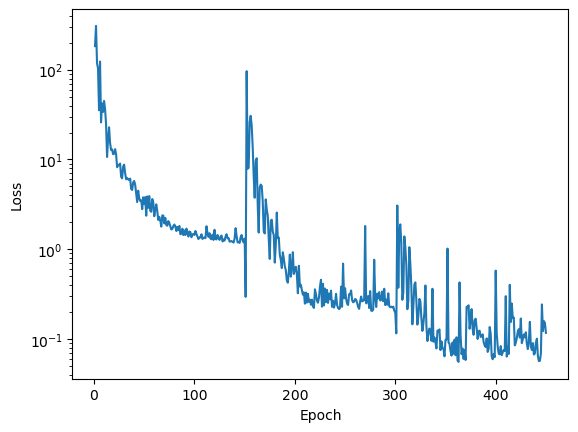

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,len(losses)+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
min(losses)

0.055290665

In [ ]:
losses.index(min(losses))

362

In [ ]:
u2model = u_model()
u2model.set_weights(uweights[362])
s2model = s_model()
s2model.set_weights(sweights[362])
c2model = c_model()
c2model.set_weights(cweights[362])

Text(0, 0.5, 'u (Temperature)')

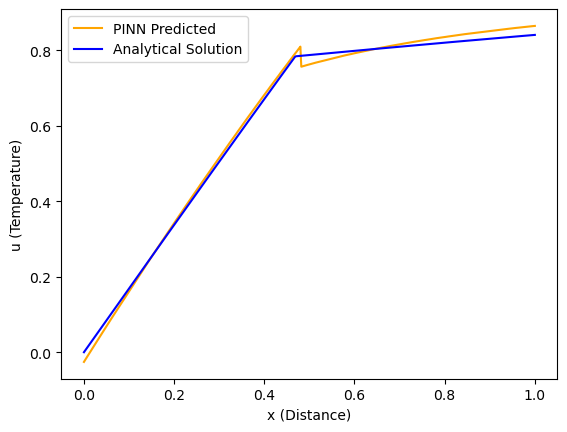

In [ ]:
N = 500
xspace = np.expand_dims(np.linspace(xmin, xmax, N+1),axis=1)
tspace = np.ones_like(xspace)*1.725
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = u2model(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = s2model(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(X,U,color='orange')
plt.plot(X,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('u (Temperature)')

In [ ]:
spred.numpy()[0][0], s_anal(T).numpy()[0][0]

(0.48149142, 0.46881524)

Text(0, 0.5, 'c (Concentration)')

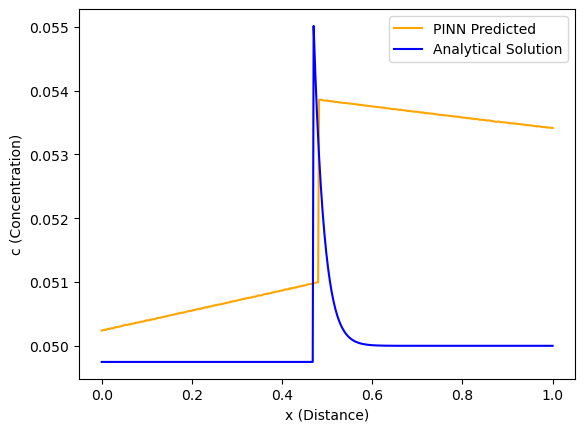

In [ ]:
cpred = c2model(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(X,C,color='orange')
plt.plot(X,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('x (Distance)')
plt.ylabel('c (Concentration)')

Text(0, 0.5, 'u (Temperature)')

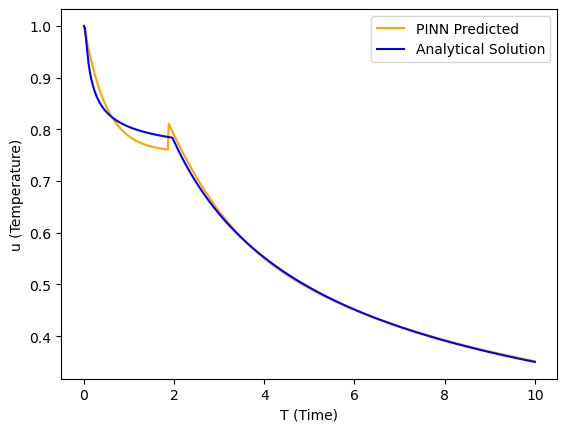

In [ ]:
N = 500
tspace = np.expand_dims(np.linspace(tmin, tmax, N+1),axis=1)
xspace = np.ones_like(tspace)*0.5
X = tf.cast(xspace,DTYPE)
T = tf.cast(tspace,DTYPE)
upred = u2model(tf.concat([T, X], axis=1))
u1p, u2p = upred[:, 0:1], upred[:, 1:2]
spred = s2model(T)
up = tf.where(tf.math.greater(spred,X), u1p, u2p)
U = up.numpy()
utrue = u_anal(T,X)
UT = utrue.numpy()
plt.plot(T,U,color='orange')
plt.plot(T,UT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('T (Time)')
plt.ylabel('u (Temperature)')

Text(0, 0.5, 'c (Concentration)')

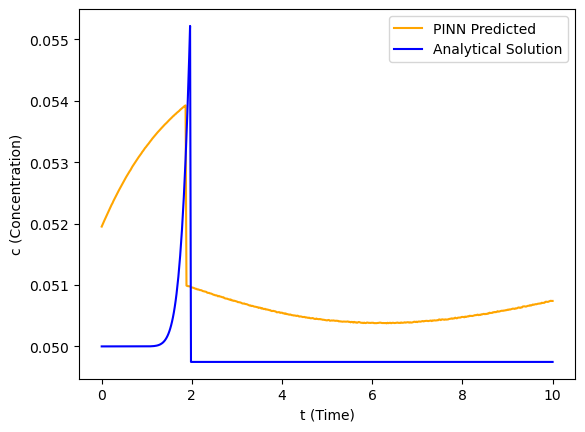

In [ ]:
cpred = c2model(tf.concat([T, X], axis=1))
c1p, c2p = cpred[:,0:1], cpred[:,1:2]
cp = tf.where(tf.math.greater(spred,X), c1p, c2p)
C = cp.numpy()
ctrue = c_anal(T,X)
CT = ctrue.numpy()
plt.plot(T,C,color='orange')
plt.plot(T,CT,color='blue')
plt.legend(['PINN Predicted','Analytical Solution'])
plt.xlabel('t (Time)')
plt.ylabel('c (Concentration)')

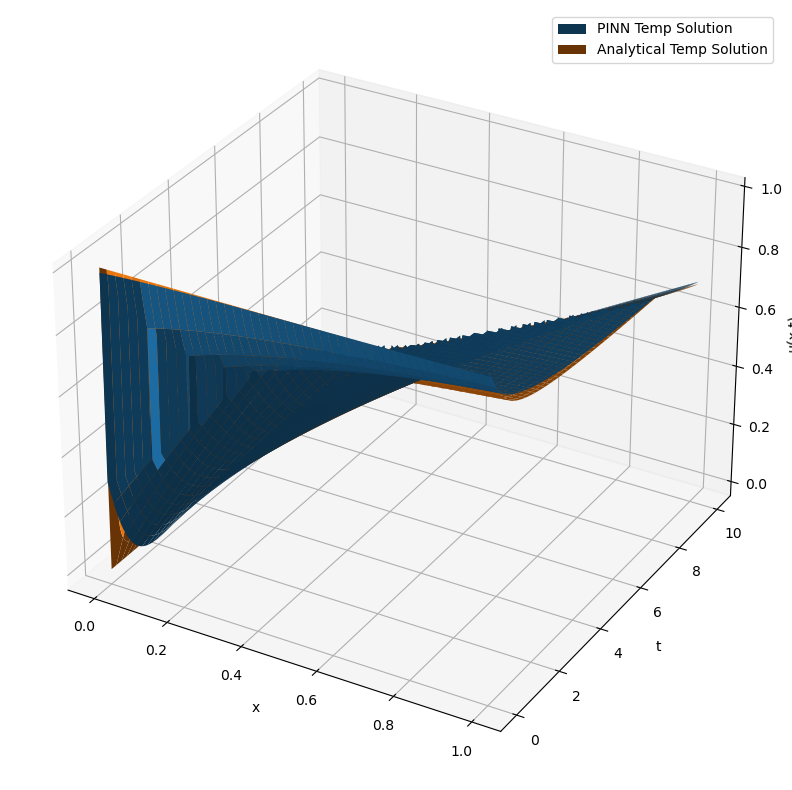

In [ ]:
N = 500
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = u2model(input)
u1_p, u2_p = u_pred[:, 0:1], u_pred[:, 1:2]
s_pred = s2model(T.flatten())
x_inp = np.expand_dims(X.flatten(),-1)
up = tf.where(tf.math.greater(s_pred,x_inp), u1_p, u2_p)
U = up.numpy().reshape(N+1,N+1)
t,x = tf.cast(T,DTYPE),tf.cast(X,DTYPE)
u_true = u_anal(t,x)
UT = u_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
c1 = ax.plot_surface(X, T, U, label = 'PINN Temp Solution')
c1._facecolors2d = c1._facecolor3d
c1._edgecolors2d = c1._edgecolor3d
c2 = ax.plot_surface(X, T, UT, label = 'Analytical Temp Solution')
c2._facecolors2d = c2._facecolor3d
c2._edgecolors2d = c2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.legend()

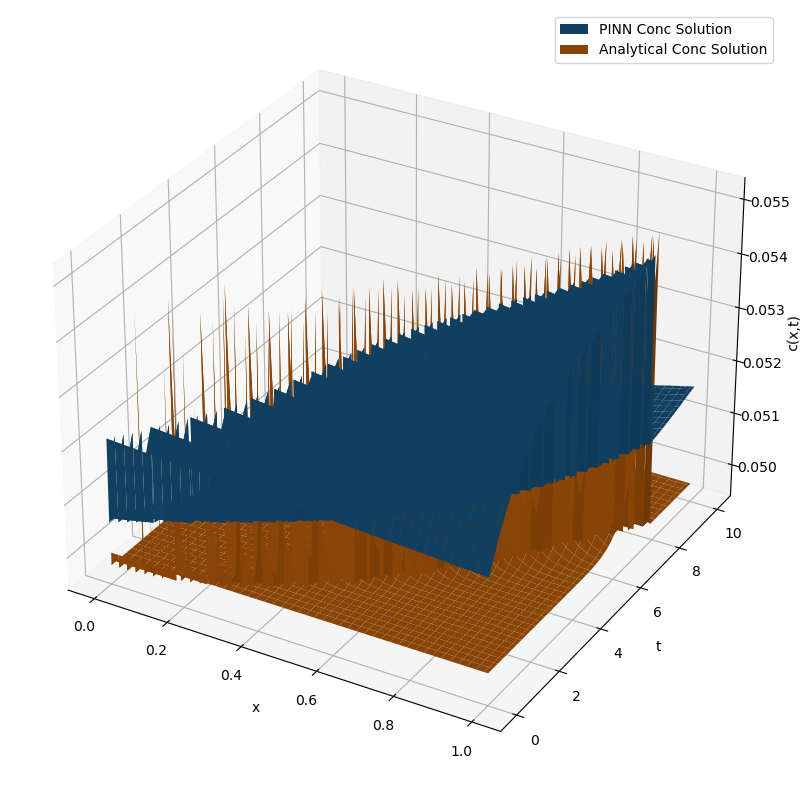

In [ ]:
c_pred = c2model(input)
c1_p, c2_p = c_pred[:, 0:1], c_pred[:, 1:2]
cp = tf.where(tf.math.greater(s_pred,x_inp), c1_p, c2_p)
C = cp.numpy().reshape(N+1,N+1)
c_true = c_anal(t,x)
CT = c_true.numpy().reshape(N+1,N+1)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
c1 = ax.plot_surface(X, T, C, label = 'PINN Conc Solution')
c1._facecolors2d = c1._facecolor3d
c1._edgecolors2d = c1._edgecolor3d
c2 = ax.plot_surface(X, T, CT, label = 'Analytical Conc Solution')
c2._facecolors2d = c2._facecolor3d
c2._edgecolors2d = c2._edgecolor3d
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('c(x,t)')
ax.legend()

Text(0.5, 1.0, 'Predicted vs Actual Movement of Interface')

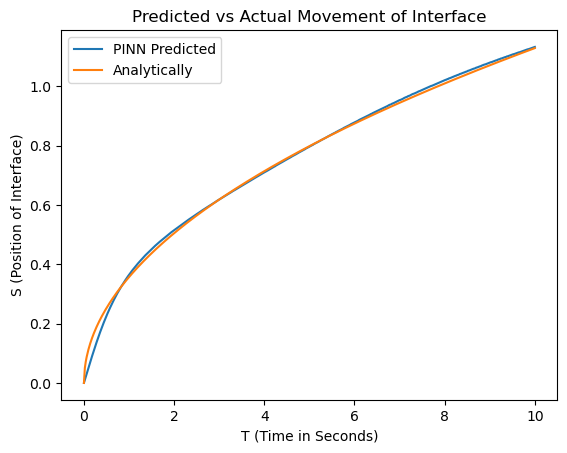

In [ ]:
t_values = tf.cast(tspace,DTYPE)
s_values = s2model(t_values)
s_exact = s_anal(t_values)
plt.plot(t_values,s_values)
plt.plot(t_values,s_exact)
plt.legend(['PINN Predicted','Analytically'])
plt.xlabel('T (Time in Seconds)')
plt.ylabel('S (Position of Interface)')
plt.title('Predicted vs Actual Movement of Interface')

In [ ]:
u2model.save('UMCT8')
s2model.save('SMCT8')
c2model.save('CMCT8')

INFO:tensorflow:Assets written to: UMCT8\assets
INFO:tensorflow:Assets written to: SMCT8\assets
INFO:tensorflow:Assets written to: CMCT8\assets
